## Data Merge 

In [ ]:
import os
import glob
import time

import polars as pl
import pandas as pd  # Used for CSV to XLSX conversion

# --- CONSTANTS ---
VERBOSE_PER_FILE_LOGGING = False  # If True, print detailed log per file
IGNORE_READ_ERRORS_IN_RAW_FILES = False  # If True, skip rows with parsing errors in Polars

# Folder structure constants (relative to script location)
RAW_DATASETS_SUBFOLDER = os.path.join("..", "Datasets", "Raw_Datasets")
FULL_DATASETS_SUBFOLDER = os.path.join("..", "Datasets", "Full_Datasets")
MASTER_DATA_SUBFOLDER = os.path.join(FULL_DATASETS_SUBFOLDER, "MasterData")

# CSV and XLSX output filenames
MASTER_CSV_FILENAME = "MasterDataSales.csv"
MASTER_XLSX_FILENAME = "MasterDataSales.xlsx"
CATEGORY_SUMMARY_FILENAME = "category_processing_summary.csv"

# Excel sheet name for Polars to read back XLSX
EXCEL_SHEET_NAME = "MasterDataSales"

# Category definitions mapping: category name -> relative raw folder path
CATEGORY_DEFINITIONS = {
    "Laptops": "laptops",
    "Mobiles": "mobiles",
    "AC": os.path.join("other_electronics", "ac"),
    "Fridge": os.path.join("other_electronics", "fridge"),
    "Smartwatch": os.path.join("other_electronics", "smartwatch"),
    "Washingmachine": os.path.join("other_electronics", "washingmachine"),
    "Waterpurifier": os.path.join("other_electronics", "waterpurifier"),
    "Earbuds": os.path.join("peripherals", "earbuds"),
    "HDD": os.path.join("peripherals", "hdd"),
    "Memory_Cards": os.path.join("peripherals", "memory_cards"),
    "Monitor": os.path.join("peripherals", "monitor"),
    "Pen_Drives": os.path.join("peripherals", "pen_drives"),
    "Power_Bank": os.path.join("peripherals", "power_bank"),
    "SSD": os.path.join("peripherals", "ssd"),
    "Wired_Headset": os.path.join("peripherals", "wired_headset"),
    "Tablet": "tablet",
    "TVs": "tvs",
}

# --- FUNCTIONS ---


def analyze_csv_header(file_path: str) -> tuple[list[str], bool]:
    """
    Analyze CSV header using Polars.
    Returns a tuple of (column_names, is_empty_or_error).
    """
    try:
        header_df = pl.read_csv(
            file_path, n_rows=0, infer_schema_length=0, ignore_errors=IGNORE_READ_ERRORS_IN_RAW_FILES
        )
        if header_df.width > 0:
            return header_df.columns, False
        else:
            return [], True
    except pl.exceptions.NoDataError:
        return [], True
    except Exception:
        return [], True


def prepare_df_for_excel_polars(df: pl.DataFrame) -> pl.DataFrame:
    """
    Modify a Polars DataFrame before writing to Excel:
    - Prefix 'item_link' values with an apostrophe to ensure Excel treats them as text.
    """
    if "item_link" in df.columns:
        df = df.with_columns(
            pl.when(pl.col("item_link").is_not_null() & (pl.col("item_link") != ""))
            .then(pl.lit("'") + pl.col("item_link"))
            .otherwise(pl.col("item_link"))
            .alias("item_link")
        )
    return df


def prepare_df_for_excel_pandas(df: pd.DataFrame) -> pd.DataFrame:
    """
    Modify a Pandas DataFrame before writing to Excel:
    - Prefix 'item_link' values with an apostrophe to ensure Excel treats them as text.
    """
    if "item_link" in df.columns:
        df["item_link"] = df["item_link"].astype(str).apply(
            lambda x: f"'{x}" if x not in [None, "", "nan", "NaN", "<NA>"] else x
        )
    return df


def process_individual_categories_to_csv(
    base_raw_path: str, base_full_path: str, category_definitions: dict
) -> tuple[list[str], list[dict]]:
    """
    Process each category folder under base_raw_path:
    - Read CSV files in category folder
    - Concatenate them into a single Polars DataFrame per category
    - Add 'product_category' column
    - Write out Full_{CategoryName}.csv under base_full_path/CSV/
    Returns:
        - List of generated full CSV file paths
        - Summary list of dicts with processing statistics per category
    """
    print("Starting category processing (output: one CSV per category)...")
    output_csv_folder = os.path.join(base_full_path, "CSV")
    os.makedirs(output_csv_folder, exist_ok=True)
    print(f"Category CSVs will be saved in: {os.path.abspath(output_csv_folder)}")

    generated_full_csv_files: list[str] = []
    all_categories_summary: list[dict] = []
    total_rows_read_from_raw_files = 0

    for category_name, rel_path in category_definitions.items():
        cat_folder = os.path.join(base_raw_path, rel_path)
        start_time = time.time()
        print(f"\nProcessing Category: {category_name}")
        csv_files = sorted(glob.glob(os.path.join(cat_folder, "*.csv")))

        if not csv_files:
            all_categories_summary.append(
                {
                    "Category": category_name,
                    "Status": "No CSV files",
                    "Files Found": 0,
                    "Files Processed": 0,
                    "Rows Read Raw": 0,
                    "Total Rows Merged": 0,
                    "Read Errors": [],
                    "Time Taken (s)": 0,
                    "CSV Output": "N/A",
                }
            )
            continue

        dataframes_cat: list[pl.DataFrame] = []
        processed_count = 0
        read_errors_cat: list[str] = []
        rows_read_this_category = 0

        for fp in csv_files:
            filename = os.path.basename(fp)
            cols, is_empty = analyze_csv_header(fp)
            if is_empty or not cols:
                read_errors_cat.append(f"{filename} (Empty/No Header)")
                continue

            try:
                df = pl.read_csv(
                    fp,
                    schema_overrides={col: pl.Utf8 for col in cols},
                    infer_schema_length=0,
                    ignore_errors=IGNORE_READ_ERRORS_IN_RAW_FILES,
                )
                rows_read_this_category += df.height
                dataframes_cat.append(df)
                processed_count += 1
            except Exception as e:
                read_errors_cat.append(f"{filename} ({type(e).__name__})")

        total_rows_read_from_raw_files += rows_read_this_category

        if not dataframes_cat:
            all_categories_summary.append(
                {
                    "Category": category_name,
                    "Status": "No valid data",
                    "Files Found": len(csv_files),
                    "Files Processed": processed_count,
                    "Rows Read Raw": rows_read_this_category,
                    "Total Rows Merged": 0,
                    "Read Errors": read_errors_cat,
                    "Time Taken (s)": round(time.time() - start_time, 2),
                    "CSV Output": "N/A",
                }
            )
            continue

        if processed_count < len(csv_files):
            print(f"  INFO: Processed {processed_count}/{len(csv_files)} files successfully in '{category_name}'.")

        # Concatenate DataFrames for this category
        full_df = pl.concat(dataframes_cat, how="diagonal_relaxed")
        full_df = full_df.with_columns(pl.lit(category_name).alias("product_category"))
        print(
            f"  Category '{category_name}' concatenated: "
            f"Rows={full_df.height}, Cols={full_df.width} "
            f"(from {rows_read_this_category} raw rows read)"
        )

        # Sanitize category name for file naming
        sani_cat_name = category_name.replace(" ", "_").replace("/", "_")
        csv_output_path = os.path.join(output_csv_folder, f"Full_{sani_cat_name}.csv")
        try:
            full_df.write_csv(csv_output_path, null_value="NaN")
            generated_full_csv_files.append(csv_output_path)
            csv_stat = os.path.basename(csv_output_path)
            print(f"  Saved Full CSV: {csv_stat}")
        except Exception as e:
            csv_stat = f"Failed: {e}"
            print(f"  ERROR saving Full CSV for '{category_name}': {e}")

        all_categories_summary.append(
            {
                "Category": category_name,
                "Status": "Processed",
                "Files Found": len(csv_files),
                "Files Processed": processed_count,
                "Rows Read Raw": rows_read_this_category,
                "Total Rows Merged": full_df.height,
                "Read Errors": read_errors_cat,
                "Time Taken (s)": round(time.time() - start_time, 2),
                "CSV Output": csv_stat,
            }
        )

    print(f"\nTotal rows read from all raw category files: {total_rows_read_from_raw_files}")
    return generated_full_csv_files, all_categories_summary


def create_master_csv_with_polars(
    category_csv_paths: list[str], output_master_folder: str
) -> tuple[str | None, int]:
    """
    Merge all Full_{Category}.csv files into a single MasterDataSales.csv using Polars.
    Returns:
        - Path to master CSV if successful, else None
        - Number of rows in master (from Polars or verified on disk)
    """
    print("\n\n--- Creating MasterDataSales.csv with Polars ---")
    master_csv_rows_intended = 0

    if not category_csv_paths:
        print("No category CSVs provided. Skipping master CSV creation.")
        return None, master_csv_rows_intended

    os.makedirs(output_master_folder, exist_ok=True)
    print(f"Merging {len(category_csv_paths)} Full_{'{Category}'}.csv files...")

    all_dfs_for_master: list[pl.DataFrame] = []
    for fp_cat_csv in category_csv_paths:
        filename = os.path.basename(fp_cat_csv)
        cols, is_empty = analyze_csv_header(fp_cat_csv)
        if is_empty or not cols:
            continue
        try:
            df = pl.read_csv(
                fp_cat_csv,
                schema_overrides={col: pl.Utf8 for col in cols},
                infer_schema_length=0,
                null_values=["NaN"],
            )
            if df.height > 0:
                all_dfs_for_master.append(df)
        except Exception as e:
            print(f"  ERROR reading '{filename}' for master: {e}. Skipping.")

    if not all_dfs_for_master:
        print("No valid category DataFrames to merge. Skipping master CSV creation.")
        return None, master_csv_rows_intended

    master_df = pl.concat(all_dfs_for_master, how="diagonal_relaxed")
    master_csv_rows_intended = master_df.height
    print(
        f"  Master DataFrame in memory: Rows={master_csv_rows_intended}, "
        f"Cols={master_df.width}"
    )

    master_csv_path = os.path.join(output_master_folder, MASTER_CSV_FILENAME)
    try:
        master_df.write_csv(master_csv_path, null_value="NaN")
        print(f"  SUCCESS: Saved Master CSV: {os.path.basename(master_csv_path)} ({master_csv_rows_intended} rows intended)")

        # Verify row count on disk
        try:
            with open(master_csv_path, "r", encoding="utf-8") as f_check:
                line_count_on_disk = sum(1 for _ in f_check)
            actual_data_rows_on_disk = line_count_on_disk - 1  # subtract header
            print(
                f"  VERIFICATION: Lines in '{os.path.basename(master_csv_path)}' on disk: "
                f"{line_count_on_disk} (Data rows: {actual_data_rows_on_disk})"
            )
            if actual_data_rows_on_disk != master_csv_rows_intended:
                print(
                    f"  WARNING: Row count mismatch! In-memory: {master_csv_rows_intended}, "
                    f"On-disk: {actual_data_rows_on_disk}"
                )
            master_csv_rows_intended = actual_data_rows_on_disk
        except Exception as e_verify:
            print(f"  VERIFICATION ERROR: Could not count lines in '{os.path.basename(master_csv_path)}': {e_verify}")
            # Keep in-memory count if verification fails

        return master_csv_path, master_csv_rows_intended
    except Exception as e:
        print(f"  ERROR saving Master CSV with Polars: {e}")
        return None, 0


def convert_master_csv_to_xlsx_with_pandas(
    master_csv_path: str | None, output_master_folder: str
) -> tuple[str | None, bool]:
    """
    Convert MasterDataSales.csv to MasterDataSales.xlsx using Pandas.
    Returns:
        - Path to XLSX if written successfully, else None
        - Boolean flag indicating if XLSX was written
    """
    if not master_csv_path or not os.path.exists(master_csv_path):
        print("\n--- Master XLSX Conversion Skipped: Master CSV not available. ---")
        return None, False

    os.makedirs(output_master_folder, exist_ok=True)
    print(f"\n\n--- Converting '{os.path.basename(master_csv_path)}' to XLSX with Pandas ---")

    master_xlsx_path = os.path.join(output_master_folder, MASTER_XLSX_FILENAME)
    xlsx_written = False

    try:
        df_pandas = pd.read_csv(
            master_csv_path, dtype=str, keep_default_na=False, na_values=["NaN"]
        )
        print(f"  (Read {df_pandas.shape[0]} rows, {df_pandas.shape[1]} cols with Pandas)")

        df_for_excel = prepare_df_for_excel_pandas(df_pandas.copy())

        print(f"  (Writing to XLSX: '{os.path.basename(master_xlsx_path)}' ...)")
        start_time = time.time()
        try:
            df_for_excel.to_excel(master_xlsx_path, index=False, engine="xlsxwriter")
            print(f"  SUCCESS: Saved Master XLSX with xlsxwriter: {os.path.basename(master_xlsx_path)}")
            xlsx_written = True
        except ImportError:
            print("  WARNING: 'xlsxwriter' not available. Trying 'openpyxl' engine...")
            try:
                df_for_excel.to_excel(master_xlsx_path, index=False, engine="openpyxl")
                print(f"  SUCCESS: Saved Master XLSX with openpyxl: {os.path.basename(master_xlsx_path)}")
                xlsx_written = True
            except Exception as e_openpyxl:
                print(f"  ERROR: Failed saving XLSX with openpyxl: {e_openpyxl}")
        except Exception as e_xlsxw:
            print(f"  ERROR: Failed saving XLSX with xlsxwriter: {e_xlsxw}")

        elapsed = time.time() - start_time
        if xlsx_written:
            print(f"  (XLSX writing took {elapsed:.2f} seconds)")

    except Exception as e:
        print(f"  ERROR during CSV to XLSX conversion: {e}")

    return (master_xlsx_path if xlsx_written else None), xlsx_written


def generate_master_summary_from_final_csv(master_csv_file_path: str | None, actual_rows_in_csv: int):
    """
    Generate and print summary statistics from the final MasterDataSales.csv.
    Uses Polars to count rows, columns, missing values, duplicates, etc.
    """
    if not master_csv_file_path or not os.path.exists(master_csv_file_path):
        print("\n--- Master Data Summary Skipped: Master CSV not found. ---")
        return

    print(f"\n\n--- Summary for Master CSV: '{os.path.basename(master_csv_file_path)}' ---")
    try:
        cols_summary, is_empty_summary = analyze_csv_header(master_csv_file_path)
        if is_empty_summary or not cols_summary:
            print(f"  ERROR: '{os.path.basename(master_csv_file_path)}' is empty or unreadable.")
            return

        df_master = pl.read_csv(
            master_csv_file_path,
            schema_overrides={col: pl.Utf8 for col in cols_summary},
            infer_schema_length=0,
            null_values=["NaN"],
        )
        total_rows = df_master.height
        print(f"Total Rows (Polars read): {total_rows}")
        print(f"Total Columns (Polars read): {df_master.width} (Names: {df_master.columns})")

        # Missing values per column
        print("\nMissing Value Counts per Column:")
        missing_info = []
        for col_name in df_master.columns:
            missing_count = df_master.select(pl.col(col_name).is_null().sum()).item()
            if missing_count > 0:
                pct = (missing_count / total_rows) * 100 if total_rows > 0 else 0
                missing_info.append(f"  - {col_name}: {missing_count} missing ({pct:.2f}%)")
        if missing_info:
            print("\n".join(missing_info))
        else:
            print("  No missing values in any column.")

        # Rows with any null
        rows_with_null = df_master.filter(pl.any_horizontal(pl.all().is_null())).height
        pct_rows_null = (rows_with_null / total_rows) * 100 if total_rows > 0 else 0
        print(
            f"Rows with at least one missing value: {rows_with_null} ({pct_rows_null:.2f}%)"
        )

        # Duplicate rows
        unique_count = df_master.unique(maintain_order=True).height
        duplicates = total_rows - unique_count
        print(f"Duplicate rows in Master CSV: {duplicates}")

    except Exception as e:
        print(f"  ERROR generating summary from Master CSV: {e}")


def validate_final_master_files(master_csv_path: str | None, master_xlsx_path: str | None, xlsx_written: bool):
    """
    Validate that the Master CSV and Master XLSX files have matching content:
    - Read CSV with Polars
    - Read XLSX with Polars
    - Compare row counts and column names/order
    """
    if not master_csv_path or not os.path.exists(master_csv_path):
        print("\n--- Master File Validation Skipped: Master CSV not found. ---")
        return

    print("\n\n--- Validating Master Files (CSV vs XLSX) ---")
    df_csv_val = None
    df_xlsx_val = None
    csv_attrs = {"rows": -1, "cols": -1, "names": []}
    xlsx_attrs = {"rows": -1, "cols": -1, "names": []}

    # Validate CSV
    print(f"Validating CSV: '{os.path.basename(master_csv_path)}'")
    try:
        cols_csv_val, is_empty_csv_val = analyze_csv_header(master_csv_path)
        if not is_empty_csv_val and cols_csv_val:
            df_csv_val = pl.read_csv(
                master_csv_path,
                schema_overrides={col: pl.Utf8 for col in cols_csv_val},
                infer_schema_length=0,
                null_values=["NaN"],
            )
            csv_attrs["rows"] = df_csv_val.height
            csv_attrs["cols"] = df_csv_val.width
            csv_attrs["names"] = df_csv_val.columns
            print(f"  Master CSV: Rows={csv_attrs['rows']}, Cols={csv_attrs['cols']}")
        else:
            print(f"  ERROR: Master CSV '{os.path.basename(master_csv_path)}' is empty/unreadable.")
    except Exception as e:
        print(f"  ERROR reading Master CSV for validation: {e}")

    # Validate XLSX if it was written
    if xlsx_written and master_xlsx_path and os.path.exists(master_xlsx_path):
        print(f"\nValidating XLSX: '{os.path.basename(master_xlsx_path)}'")
        try:
            df_xlsx_val = pl.read_excel(source=master_xlsx_path, sheet_name=EXCEL_SHEET_NAME)
            xlsx_attrs["rows"] = df_xlsx_val.height
            xlsx_attrs["cols"] = df_xlsx_val.width
            xlsx_attrs["names"] = df_xlsx_val.columns
            print(f"  Master XLSX: Rows={xlsx_attrs['rows']}, Cols={xlsx_attrs['cols']}")
        except Exception as e:
            print(f"  ERROR reading Master XLSX for validation: {e}")
    else:
        print("\nMaster XLSX validation skipped (not written or path unavailable).")

    # Compare CSV vs XLSX if both available
    if csv_attrs["rows"] != -1 and xlsx_attrs["rows"] != -1:
        print("\nComparing CSV and XLSX content:")
        if csv_attrs["rows"] == xlsx_attrs["rows"]:
            print(f"  SUCCESS: Row counts match ({csv_attrs['rows']}).")
        else:
            print(
                f"  ERROR: Row count mismatch! CSV: {csv_attrs['rows']}, XLSX: {xlsx_attrs['rows']}"
            )

        if csv_attrs["names"] == xlsx_attrs["names"]:
            print(f"  SUCCESS: Column names and order match.")
        else:
            print("  ERROR: Column mismatch!")
            print(f"    CSV cols  ({csv_attrs['cols']}): {csv_attrs['names']}")
            print(f"    XLSX cols ({xlsx_attrs['cols']}): {xlsx_attrs['names']}")
    elif csv_attrs["rows"] != -1:
        print("\nValidation: Only Master CSV was available/readable. XLSX not validated.")


if __name__ == "__main__":
    overall_start = time.time()
    try:
        script_location = os.path.dirname(os.path.abspath(__file__))
    except NameError:
        print("INFO: '__file__' not defined. Using current working directory.")
        script_location = os.getcwd()
    print(f"Script running from: {script_location}")

    # Resolve dataset paths
    raw_datasets_path = os.path.normpath(os.path.join(script_location, RAW_DATASETS_SUBFOLDER))
    full_datasets_path = os.path.normpath(os.path.join(script_location, FULL_DATASETS_SUBFOLDER))
    master_data_folder = os.path.normpath(os.path.join(script_location, MASTER_DATA_SUBFOLDER))

    # Ensure master data folder exists
    os.makedirs(master_data_folder, exist_ok=True)

    if not os.path.isdir(raw_datasets_path):
        print(f"ERROR: Raw datasets path does not exist: {os.path.abspath(raw_datasets_path)}")
    else:
        # Stage 1: Process category CSV files
        category_csv_paths, category_summary = process_individual_categories_to_csv(
            raw_datasets_path, full_datasets_path, CATEGORY_DEFINITIONS
        )

        # Print and save category processing summary
        print("\n\n--- Category Processing Summary ---")
        if category_summary:
            try:
                summary_df = pl.DataFrame(category_summary)
                print(summary_df)
                summary_csv_path = os.path.join(full_datasets_path, CATEGORY_SUMMARY_FILENAME)
                summary_df.write_csv(summary_csv_path)
                print(f"Category summary saved to: {os.path.basename(summary_csv_path)}")
            except Exception as e:
                print(f"ERROR saving category summary DataFrame: {e}")
        else:
            print("No category summary data to display.")

        # Stage 2: Create MasterDataSales.csv in MASTER_DATA_SUBFOLDER
        master_csv_path, master_row_count = None, 0
        if category_csv_paths:
            master_csv_path, master_row_count = create_master_csv_with_polars(
                category_csv_paths, master_data_folder
            )
        else:
            print("\nMaster CSV creation skipped: No category CSV files generated.")

        # Stage 3: Convert MasterDataSales.csv to XLSX using Pandas (also in MASTER_DATA_SUBFOLDER)
        master_xlsx_path, xlsx_written = None, False
        if master_csv_path:
            master_xlsx_path, xlsx_written = convert_master_csv_to_xlsx_with_pandas(
                master_csv_path, master_data_folder
            )

        # Stage 4: Generate summary from final MasterDataSales.csv
        generate_master_summary_from_final_csv(master_csv_path, master_row_count)

        # Stage 5: Validate Master CSV vs Master XLSX
        validate_final_master_files(master_csv_path, master_xlsx_path, xlsx_written)

    total_elapsed = time.time() - overall_start
    print(f"\nDataset processing finished in {total_elapsed:.2f} seconds.")
    print("Note: Excel writing requires 'xlsxwriter' or 'openpyxl'. URLs in Excel are plain text.")
    if IGNORE_READ_ERRORS_IN_RAW_FILES:
        print(
            "WARNING: IGNORE_READ_ERRORS_IN_RAW_FILES is True. Row counts may be higher, "
            "but data integrity for erroneous rows is not guaranteed."
        )


INFO: '__file__' not defined. Using current working directory.
Script running from: x:\Coding Project Files\Uni_Assignment\Big_Data\UAS\Weka_SalesData\Notebooks
Starting category processing (output: one CSV per category)...
Category CSVs will be saved in: x:\Coding Project Files\Uni_Assignment\Big_Data\UAS\Weka_SalesData\Datasets\Full_Datasets\CSV

Processing Category: Laptops
  Category 'Laptops' concatenated: Rows=16848, Cols=12 (from 16848 raw rows read)
  Saved Full CSV: Full_Laptops.csv

Processing Category: Mobiles
  Category 'Mobiles' concatenated: Rows=17760, Cols=12 (from 17760 raw rows read)
  Saved Full CSV: Full_Mobiles.csv

Processing Category: AC
  Category 'AC' concatenated: Rows=6385, Cols=12 (from 6385 raw rows read)
  Saved Full CSV: Full_AC.csv

Processing Category: Fridge
  Category 'Fridge' concatenated: Rows=7440, Cols=12 (from 7440 raw rows read)
  Saved Full CSV: Full_Fridge.csv

Processing Category: Smartwatch
  Category 'Smartwatch' concatenated: Rows=7488, Co

## Data Cleaning


In [230]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# -------------------- LOAD CSV WITH PANDAS (Original Data) --------------------
df_original = pd.read_csv(
    "../Datasets/Full_Datasets/MasterData/MasterDataSales.csv",
    encoding="utf-8",
    on_bad_lines="skip",
    low_memory=False
)

# -------------------- LOAD CSV WITH PANDAS --------------------
df = pd.read_csv(
    "../Datasets/Full_Datasets/MasterData/MasterDataSales.csv",
    encoding="utf-8",
    on_bad_lines="skip",
    low_memory=False
)

# -------------------- PRINT INITIAL CHECKS --------------------
print("=== INITIAL DATAFRAME STATE ===")
print(f"Columns before cleaning: {list(df.columns)}")
print(f"Shape before cleaning: {df.shape}")
print("\nMissing values per column (before):")
print(df.isna().sum())
print(f"\nDuplicate row count (before): {df.duplicated().sum()}")

print("\nSample unique values in 'off_now' (before):")
print(df["off_now"].dropna().unique()[:20])

print("\nSample 'offer_price' and 'original_price' (first 5 rows before):")
print(df[["offer_price", "original_price"]].head(5))

=== INITIAL DATAFRAME STATE ===
Columns before cleaning: ['u_id', 'name', 'offer_price', 'original_price', 'off_now', 'total_ratings', 'total_reviews', 'rating', 'description', 'item_link', 'created_at', 'product_category']
Shape before cleaning: (177945, 12)

Missing values per column (before):
u_id                9360
name                   0
offer_price            0
original_price         0
off_now                0
total_ratings          0
total_reviews          0
rating                 0
description            0
item_link           9360
created_at             0
product_category       0
dtype: int64

Duplicate row count (before): 36

Sample unique values in 'off_now' (before):
['19% off' '32% off' '26% off' '24% off' '11% off' '27% off' '17% off'
 '39% off' '29% off' '34% off' '36% off' '42% off' '21% off' '33% off'
 '12% off' '28% off' '14% off' '48% off' '40% off' '20% off']

Sample 'offer_price' and 'original_price' (first 5 rows before):
   offer_price original_price
0        99

In [231]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer

# -------------------- LOAD & CLEAN --------------------
# Drop duplicate rows
df = df.drop_duplicates().reset_index(drop=True)

# Rename columns
df = df.rename(columns={
    "name": "product_name",
    "rating": "product_rating"
})

# Drop unnecessary columns
df = df.drop(columns=["u_id", "item_link", "created_at", "product_name", "product_category"], errors="ignore")

# Clean 'off_now'
df["off_now"] = (
    df["off_now"]
    .astype(str)
    .str.replace(r"%\s*off", "", regex=True)
    .str.replace(r"[^\d\.]", "", regex=True)
    .replace("", np.nan)
    .astype(float)
)

# Clean numeric price columns
for col in ["offer_price", "original_price"]:
    df[col] = (
        df[col]
        .astype(str)
        .str.replace(r"[^\d\.]", "", regex=True)
        .replace("", np.nan)
        .astype(float)
    )

# Convert product_rating to numeric first
df["product_rating"] = pd.to_numeric(df["product_rating"], errors="coerce")

# Replace numeric product_rating to nominal categories
def convert_rating_to_nominal(rating):
    if pd.isna(rating) or rating == 0:
        return "No Rating"
    elif rating < 3:
        return "Bad"
    elif rating < 4:
        return "Average"
    else:
        return "Good"

df["product_rating"] = df["product_rating"].apply(convert_rating_to_nominal)

# Check after cleaning
print("\n=== CLEANING DONE ===")
print("product_rating value counts:")
print(df["product_rating"].value_counts(dropna=False))
print("Missing values:\n", df.isna().sum())
print("────────────────────────────────────────────────────────")



=== CLEANING DONE ===
product_rating value counts:
product_rating
Good         96360
No Rating    41299
Average      38123
Bad           2127
Name: count, dtype: int64
Missing values:
 offer_price       0
original_price    0
off_now           0
total_ratings     0
total_reviews     0
product_rating    0
description       0
dtype: int64
────────────────────────────────────────────────────────


In [232]:

# -------------------- IMPUTATION --------------------
numeric_cols = ["offer_price", "original_price", "off_now", "total_ratings", "total_reviews"]
categorical_cols = ["product_name", "description", "product_category", "product_rating"]

# Validation: keep only existing columns
numeric_cols = [col for col in numeric_cols if col in df.columns]
categorical_cols = [col for col in categorical_cols if col in df.columns]

# Remove fully NaN columns
numeric_cols = [col for col in numeric_cols if df[col].notna().sum() > 0]
categorical_cols = [col for col in categorical_cols if df[col].notna().sum() > 0]

# Numeric imputation using mean
if numeric_cols:
    num_imputer = SimpleImputer(strategy="mean")
    df[numeric_cols] = pd.DataFrame(
        num_imputer.fit_transform(df[numeric_cols]),
        columns=numeric_cols,
        index=df.index
    )

# Categorical imputation using most frequent
if categorical_cols:
    cat_imputer = SimpleImputer(strategy="most_frequent")
    df[categorical_cols] = pd.DataFrame(
        cat_imputer.fit_transform(df[categorical_cols]),
        columns=categorical_cols,
        index=df.index
    )

# -------------------- Final Check --------------------
print("\n=== AFTER FINAL IMPUTATION ===")
print("Missing values per column:")
print(df.isna().sum())



=== AFTER FINAL IMPUTATION ===
Missing values per column:
offer_price       0
original_price    0
off_now           0
total_ratings     0
total_reviews     0
product_rating    0
description       0
dtype: int64


In [233]:
# -------------------- CONVERT REMAINING COLUMNS --------------------
df["total_ratings"] = pd.to_numeric(df["total_ratings"], errors="coerce").astype("Int64")
df["total_reviews"] = pd.to_numeric(df["total_reviews"], errors="coerce").astype("Int64")
df["description"] = df["description"].astype(str)

# -------------------- PRINT AFTER TYPE CONVERSIONS --------------------
print("\n=== AFTER TYPE CONVERSIONS ===")
print(f"Data types after conversions:\n{df.dtypes}")



=== AFTER TYPE CONVERSIONS ===
Data types after conversions:
offer_price       float64
original_price    float64
off_now           float64
total_ratings       Int64
total_reviews       Int64
product_rating     object
description        object
dtype: object


In [234]:
df.head()

,offer_price,original_price,off_now,total_ratings,total_reviews,product_rating,description
0,99990.0,124283.0,19.0,0,0,No Rating,"['AMD Ryzen 7 Octa Core Processor', '16 GB DDR..."
1,46990.0,69999.0,32.0,128,17,Good,"['Intel Core i7 Processor (10th Gen)', '16 GB ..."
2,33990.0,45990.0,26.0,3600,370,Good,"['Intel Core i3 Processor (10th Gen)', '8 GB D..."
3,43990.0,57990.0,24.0,2408,211,Good,"['Intel Core i5 Processor (10th Gen)', '8 GB D..."
4,47990.0,70990.0,32.0,1209,100,Good,"['Intel Core i5 Processor (10th Gen)', '8 GB D..."


In [235]:
import pandas as pd
from sklearn.impute import SimpleImputer

# -------------------- DEFINE COLUMNS --------------------
numeric_cols = ["offer_price", "original_price", "off_now", "total_ratings", "total_reviews"]
categorical_cols = ["product_name", "description", "product_category", "product_rating"]

# -------------------- VALIDATION --------------------
# Ensure the columns actually exist in the DataFrame
numeric_cols = [col for col in numeric_cols if col in df.columns]
categorical_cols = [col for col in categorical_cols if col in df.columns]

# Remove columns that are fully NaN (not suitable for imputation)
numeric_cols = [col for col in numeric_cols if df[col].notna().sum() > 0]
categorical_cols = [col for col in categorical_cols if df[col].notna().sum() > 0]

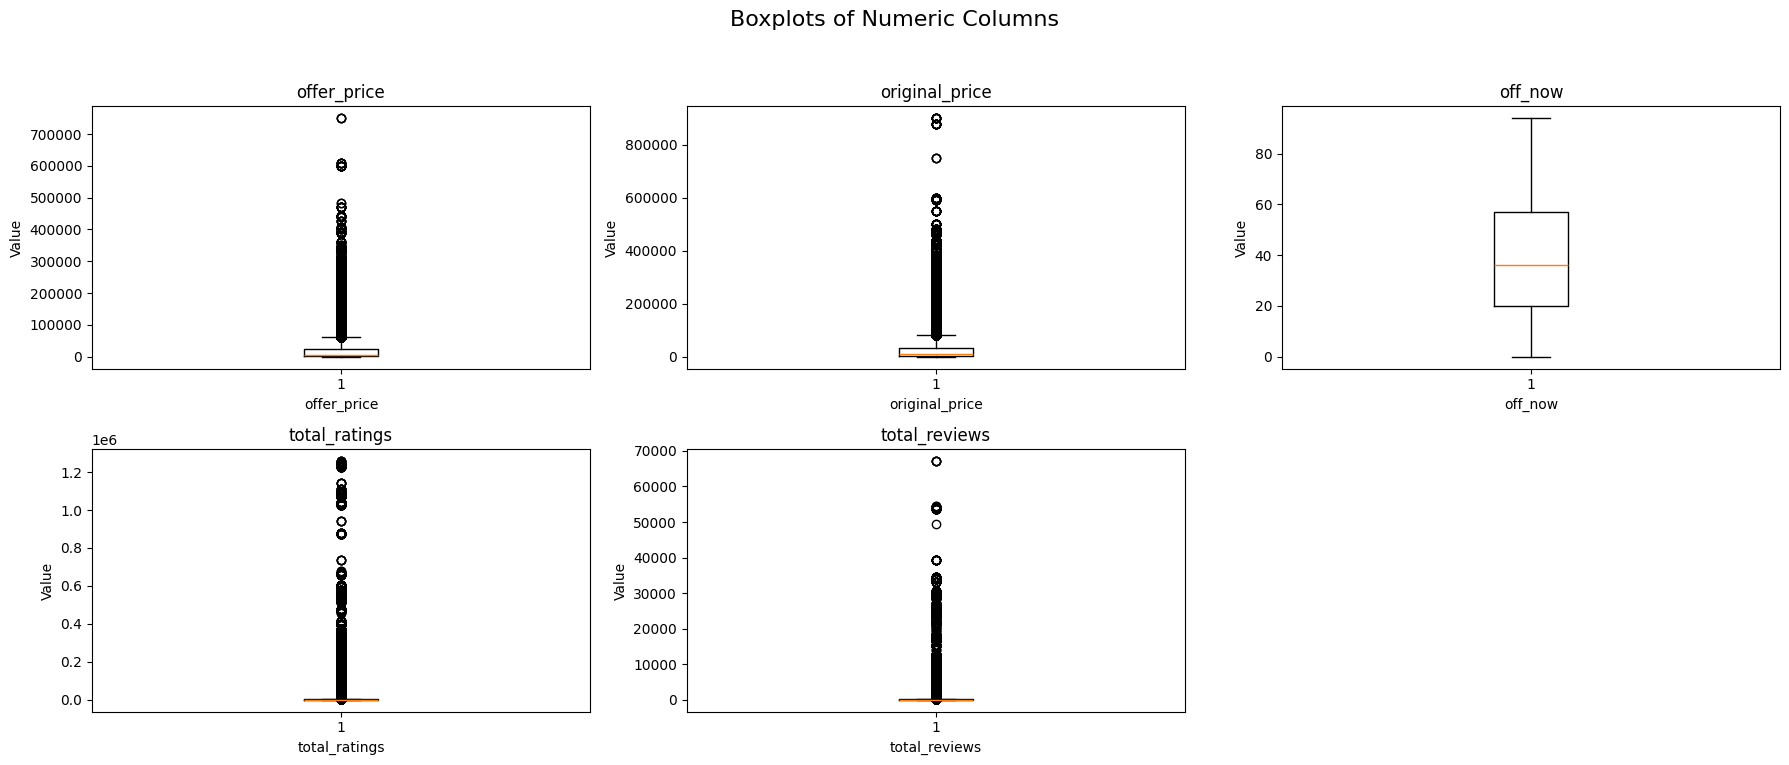

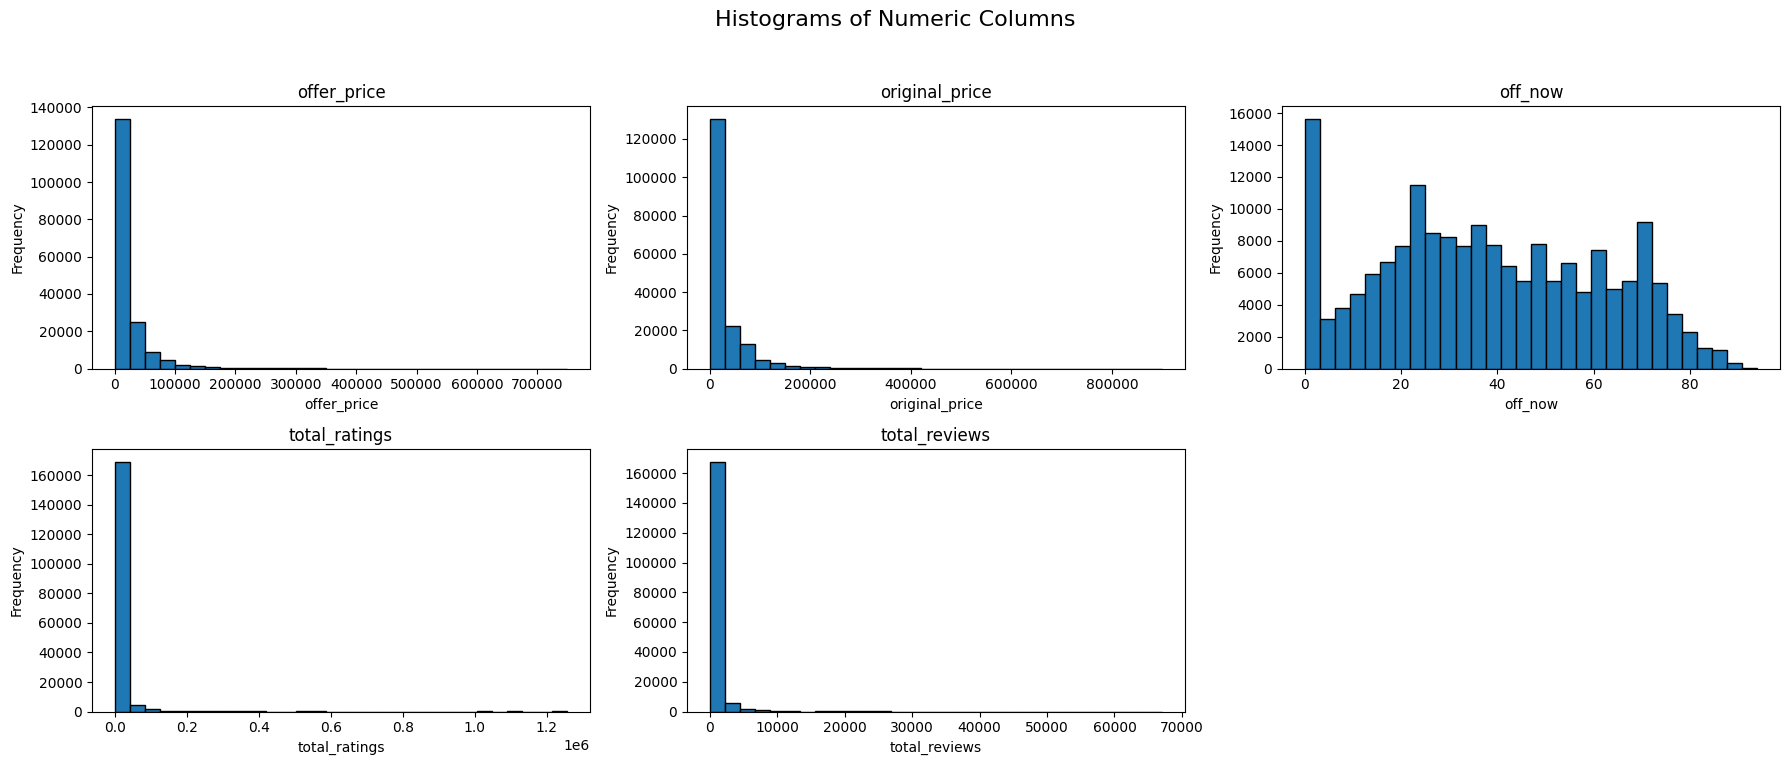


=== OUTLIER DETECTION SUMMARY (IQR METHOD) ===
  offer_price: lower=-34757.500, upper=60326.500, outliers=14819
  original_price: lower=-45987.500, upper=81976.500, outliers=14255
  off_now: lower=-35.500, upper=112.500, outliers=0
  total_ratings: lower=-3213.000, upper=5363.000, outliers=34097
  total_reviews: lower=-111.000, upper=185.000, outliers=34244


In [236]:
# -------------------- OUTLIER DETECTION VISUALIZATIONS --------------------
n_cols = 3
n_rows = -(-len(numeric_cols) // n_cols)  # Ceiling division

# --- Boxplots: 1 row 3 columns layout ---
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows))
fig.suptitle("Boxplots of Numeric Columns", fontsize=16)
axes = axes.flatten()

for idx, col in enumerate(numeric_cols):
    axes[idx].boxplot(df[col].dropna(), vert=True)
    axes[idx].set_title(f"{col}")
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel("Value")

# Hide unused subplots
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# --- Histograms: 1 row 3 columns layout ---
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows))
fig.suptitle("Histograms of Numeric Columns", fontsize=16)
axes = axes.flatten()

for idx, col in enumerate(numeric_cols):
    axes[idx].hist(df[col].dropna(), bins=30, edgecolor="black")
    axes[idx].set_title(f"{col}")
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel("Frequency")

# Hide unused subplots
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# --- Outlier Detection Summary (IQR Method) ---
print("\n=== OUTLIER DETECTION SUMMARY (IQR METHOD) ===")
for col in numeric_cols:
    series = df[col].dropna()
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    num_outliers = series[(series < lower) | (series > upper)].shape[0]
    print(f"  {col}: lower={lower:.3f}, upper={upper:.3f}, outliers={num_outliers}")

In [237]:
# -------------------- PRINT ORIGINAL DATASET SUMMARY --------------------
print("=== ORIGINAL DATAFRAME STATE ===")
print(f"Total rows (original): {df_original.shape[0]}")
print(f"Total columns (original): {df_original.shape[1]}")
print(f"\nMissing values per column (original):")
print(df_original.isna().sum())
print(f"\nDuplicate rows count (original): {df_original.duplicated().sum()}")

=== ORIGINAL DATAFRAME STATE ===
Total rows (original): 177945
Total columns (original): 12

Missing values per column (original):
u_id                9360
name                   0
offer_price            0
original_price         0
off_now                0
total_ratings          0
total_reviews          0
rating                 0
description            0
item_link           9360
created_at             0
product_category       0
dtype: int64

Duplicate rows count (original): 36


In [238]:
# -------------------- FINAL SUMMARY AFTER CLEANING --------------------
print("\n=== FINAL CLEANED DATAFRAME STATE ===")
print(f"Total rows (cleaned): {df.shape[0]}")
print(f"Total columns (cleaned): {df.shape[1]}")
print(f"\nMissing values per column (cleaned):")
print(df.isna().sum())
print(f"\nDuplicate rows count (cleaned): {df.duplicated().sum()}")
print("\nData types (cleaned):")
print(df.dtypes)


=== FINAL CLEANED DATAFRAME STATE ===
Total rows (cleaned): 177909
Total columns (cleaned): 7

Missing values per column (cleaned):
offer_price       0
original_price    0
off_now           0
total_ratings     0
total_reviews     0
product_rating    0
description       0
dtype: int64

Duplicate rows count (cleaned): 108854

Data types (cleaned):
offer_price       float64
original_price    float64
off_now           float64
total_ratings       Int64
total_reviews       Int64
product_rating     object
description        object
dtype: object


In [239]:
df.count()

offer_price       177909
original_price    177909
off_now           177909
total_ratings     177909
total_reviews     177909
product_rating    177909
description       177909
dtype: int64

In [240]:
df.head

<bound method NDFrame.head of         offer_price  original_price  off_now  total_ratings  total_reviews  \
0           99990.0        124283.0     19.0              0              0   
1           46990.0         69999.0     32.0            128             17   
2           33990.0         45990.0     26.0           3600            370   
3           43990.0         57990.0     24.0           2408            211   
4           47990.0         70990.0     32.0           1209            100   
...             ...             ...      ...            ...            ...   
177904       5088.0         12999.0     60.0          11005           1581   
177905      14964.0         19990.0     25.0           2561            347   
177906      20825.0         32039.0     35.0              5              0   
177907      85700.0        145900.0     41.0             24              2   
177908       6599.0         15999.0     58.0            776            106   

       product_rating            

In [241]:
file_name = "../Datasets/Full_Datasets/FinalDataCSV/FinalDataSales.csv"
os.makedirs(os.path.dirname(file_name), exist_ok=True)
df.to_csv(file_name, index=False)

print(f"Data saved to {file_name}")

Data saved to ../Datasets/Full_Datasets/FinalDataCSV/FinalDataSales.csv


## Data Saving 


In [242]:
import pandas as pd
import numpy as np
import os

# Load CSV dan bersihkan nama kolom
df = pd.read_csv("../Datasets/Full_Datasets/FinalDataCSV/FinalDataSales.csv")
df.columns = [col.strip().replace(" ", "_").replace("-", "_") for col in df.columns]

# Ganti NaN dengan tanda ? (Weka-compatible)
df = df.replace({np.nan: "?"})

# Tentukan tipe atribut untuk ARFF
attributes = []
for col in df.columns:
    col_data = df[col]

    if col == "description":
        # Perlakukan 'description' sebagai STRING apa pun isinya
        attributes.append((col, "STRING"))
        continue

    if col_data.dtype == object or col_data.dtype.name == "category":
        unique_vals = col_data.dropna().unique()
        if 1 < len(unique_vals) <= 50:
            cleaned_vals = sorted(set(str(v).strip().replace("'", "").replace('"', "") for v in unique_vals))
            attributes.append((col, cleaned_vals))
        else:
            top_vals = col_data.value_counts().index[:50]
            cleaned_vals = sorted(set(str(v).strip().replace("'", "").replace('"', "") for v in top_vals))
            attributes.append((col, cleaned_vals))
            df[col] = df[col].apply(lambda x: x if x in top_vals else "?")
            print(f"⚠️ Column '{col}' has too many unique categories. Truncated to top 50 values.")
    else:
        attributes.append((col, "NUMERIC"))

# Escape value agar aman untuk ARFF
def escape_value(val):
    if val == "?":
        return val
    if isinstance(val, str):
        val = val.replace("\\", "\\\\").replace("'", "\\'").replace("\n", " ").replace("\r", " ").strip()
        return f"'{val}'"
    return val

# Konversi seluruh data menjadi baris untuk ARFF
data_rows = [[escape_value(cell) for cell in row] for row in df.values.tolist()]

# Bangun isi file ARFF
arff_lines = ["@RELATION FinalDataSales\n"]
for attr_name, attr_type in attributes:
    if isinstance(attr_type, list):
        enum_vals = ",".join(f"'{v}'" for v in attr_type)
        arff_lines.append(f"@ATTRIBUTE {attr_name} {{{enum_vals}}}")
    else:
        arff_lines.append(f"@ATTRIBUTE {attr_name} {attr_type}")
arff_lines.append("\n@DATA")
arff_lines.extend([",".join(map(str, row)) for row in data_rows])

# Simpan ke file .arff
output_path = "../Datasets/Full_Datasets/ARFF/FinalDataSales.arff"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
with open(output_path, "w", encoding="utf-8") as f:
    f.write("\n".join(arff_lines))

print(f"\n✅ ARFF file saved: {output_path}")
print("📦 'description' stored as STRING. No truncation applied.")



✅ ARFF file saved: ../Datasets/Full_Datasets/ARFF/FinalDataSales.arff
📦 'description' stored as STRING. No truncation applied.
